In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import seaborn as sns
import numpy as np

In [3]:
import growth_curve_analysis as od

In [4]:
def transform(x):
    if x > 0.6:
        y = np.around(0.2141*np.exp(1.7935*x), 3)
    else: y = x
    return y

In [ ]:
# for one date
d = '20160727'
blank_file = pd.read_excel('/Users/nwespe/Dropbox/Research - Data/PG GC Experiments/gen_blank_file.xlsx')
data = pd.read_csv('/Users/nwespe/Dropbox/Research - Data/PG GC Experiments/Original Data Files/'+d+'/'+d+' ypd nacl data.txt', 
                    sep='\t', converters ={'strain': lambda x: str(x), 'name': lambda x: str(x)})
no_time = data.iloc[:, 1:]
blanked_data = pd.DataFrame(no_time.values-blank_file.values, columns=no_time.columns)
adj_data = blanked_data.applymap(transform)
#adj_data['Kinetic read'] = data['Kinetic read']

In [ ]:
data[:4]

In [52]:
# for multiple dates
dates = ['20160719', '20160720', '20160721', '20160727', '20160728', '20160802', '20160913', '20160922', '20161005']
data_dict = {}
layout_dict = {}
blank_file = pd.read_excel('/Users/nwespe/Dropbox/Research - Data/PG GC Experiments/gen_blank_file.xlsx')
for d in dates:
    #data_dict[d] = pd.read_csv('/Users/nwespe/Dropbox/Research - Data/PG GC Experiments/Original Data Files/'+d+'/'+d+' ypd nacl data.txt', sep='\t')
    data = pd.read_csv('/Users/nwespe/Dropbox/Research - Data/PG GC Experiments/Original Data Files/'+d+'/'+d+' ypd nacl data.txt', 
                       sep='\t', converters ={'strain': lambda x: str(x), 'name': lambda x: str(x)})
    no_time = data.iloc[:, 1:]
    blanked_data = pd.DataFrame(no_time.values-blank_file.values, columns=no_time.columns)
    adj_data = blanked_data.applymap(transform)
    adj_data['Kinetic read'] = data['Kinetic read']
    data_dict[d] = adj_data
    layout_dict[d] = pd.read_excel('/Users/nwespe/Dropbox/Research - Data/PG GC Experiments/Original Data Files/'+d+'/'+d+' ypd nacl layout.xlsx', 
                                   converters ={'strain': lambda x: str(x), 'name': lambda x: str(x)})
    adj_data.to_excel('/Users/nwespe/Dropbox/Research - Data/PG GC Experiments/Adjusted Data/'+d+' adjusted data.xlsx')

In [6]:
data_dict.keys()

['20160922',
 '20160719',
 '20160728',
 '20161005',
 '20160727',
 '20160913',
 '20160802',
 '20160720',
 '20160721']

In [ ]:
data_dict['20160719'][:4]

In [7]:
def reformat_time(x):
    if type(x) not in ['int64', 'float64']:  # if numeric, assume minutes
        elapsed_time = od.reformat_time(str(x))
    else: elapsed_time = x
    time_in_hours = elapsed_time/60
    return time_in_hours

In [53]:
# create aggregate data file with columns: times, expt_date, well, name, media, replicate, run, strain, clone, OD600
all_data = []
for d in dates:
    orig_data = data_dict[d]
    orig_data['time'] = orig_data['Kinetic read'].apply(lambda x: reformat_time(x))
    flipped_data = orig_data.T
    flipped_data.columns = flipped_data.loc['time']
    flipped_data.drop(['Kinetic read', 'time'], inplace=True)
    layout = layout_dict[d]
    keyed_data = pd.merge(flipped_data, layout, right_on='well', left_index=True)
    all_data.append(keyed_data)
data = pd.concat(all_data)
trimmed_data = data.drop(['run', 'strain', 'clone', 'replicate'], axis=1)

In [9]:
trimmed_data[:4]

,0.0,0.166666666667,0.333333333333,0.5,0.666666666667,0.833333333333,1.0,1.16666666667,1.33333333333,1.5,...,19.1666666667,19.3333333333,19.5,19.6666666667,19.8333333333,20.0,expt_date,media,name,well
0,0.124,0.134,0.146,0.161,0.177,0.192,0.209,0.231,0.25,0.268,...,NaN,NaN,NaN,NaN,NaN,NaN,2016-07-19,YPD,003,A1
1,0.119,0.127,0.143,0.156,0.17,0.189,0.205,0.223,0.245,0.267,...,NaN,NaN,NaN,NaN,NaN,NaN,2016-07-19,YPD,003,A2
2,0.139,0.148,0.164,0.178,0.193,0.212,0.225,0.242,0.263,0.284,...,NaN,NaN,NaN,NaN,NaN,NaN,2016-07-19,YPD,006A,A3
3,0.125,0.134,0.147,0.16,0.171,0.187,0.201,0.219,0.237,0.257,...,NaN,NaN,NaN,NaN,NaN,NaN,2016-07-19,YPD,006A,A4


In [54]:
norm_data_dict = {}
for d in dates:
    orig_data = data_dict[d]
    orig_data['time'] = orig_data['Kinetic read'].apply(lambda x: reformat_time(x))
    times = orig_data['time']
    only_ODs = orig_data.drop(['Kinetic read', 'time'], axis=1)
    norm_data = only_ODs/only_ODs.iloc[0]
    norm_data['time'] = times
    norm_data_dict[d] = norm_data
    
all_norm_data = []
for d in dates:
    orig_data = norm_data_dict[d]
    flipped_data = orig_data.T
    flipped_data.columns = flipped_data.loc['time']
    flipped_data.drop('time', inplace=True)
    layout = layout_dict[d]
    keyed_data = pd.merge(flipped_data, layout, right_on='well', left_index=True)
    all_norm_data.append(keyed_data)
    
norm_data_df = pd.concat(all_norm_data)
trimmed_norm_data = norm_data_df.drop(['run', 'strain', 'clone', 'replicate'], axis=1)

In [55]:
log_data_dict = {}
for d in dates:
    orig_data = data_dict[d]
    orig_data['time'] = orig_data['Kinetic read'].apply(lambda x: reformat_time(x))
    times = orig_data['time']
    only_ODs = orig_data.drop(['Kinetic read', 'time'], axis=1)
    log_data = np.log(only_ODs)
    log_data['time'] = times
    log_data_dict[d] = log_data

all_log_data = []
for d in dates:
    orig_data = log_data_dict[d]
    flipped_data = orig_data.T
    flipped_data.columns = flipped_data.loc['time']
    flipped_data.drop('time', inplace=True)
    layout = layout_dict[d]
    keyed_data = pd.merge(flipped_data, layout, right_on='well', left_index=True)
    all_log_data.append(keyed_data)
    
log_data_df = pd.concat(all_log_data)
trimmed_log_data = log_data_df.drop(['run', 'strain', 'clone', 'replicate'], axis=1)

In [56]:
log_norm_data_dict = {}
for d in dates:
    norm_data = norm_data_dict[d]
    times = norm_data['time']
    only_ODs = norm_data.drop(['time'], axis=1)
    log_norm_data = np.log(only_ODs)
    log_norm_data['time'] = times
    log_norm_data_dict[d] = log_norm_data

all_log_norm_data = []
for d in dates:
    orig_data = log_norm_data_dict[d]
    flipped_data = orig_data.T
    flipped_data.columns = flipped_data.loc['time']
    flipped_data.drop('time', inplace=True)
    layout = layout_dict[d]
    keyed_data = pd.merge(flipped_data, layout, right_on='well', left_index=True)
    all_log_norm_data.append(keyed_data)
    
log_norm_data_df = pd.concat(all_log_norm_data)
trimmed_log_norm_data = log_norm_data_df.drop(['run', 'strain', 'clone', 'replicate'], axis=1)

In [13]:
subtracted_data_dict = {}
for d in dates:
    orig_data = data_dict[d]
    orig_data['time'] = orig_data['Kinetic read'].apply(lambda x: reformat_time(x))
    times = orig_data['time']
    only_ODs = orig_data.drop(['Kinetic read', 'time'], axis=1)
    subtracted_data = only_ODs - only_ODs.iloc[0]
    subtracted_data['time'] = times
    subtracted_data_dict[d] = subtracted_data
    
all_subtracted_data = []
for d in dates:
    orig_data = subtracted_data_dict[d]
    flipped_data = orig_data.T
    flipped_data.columns = flipped_data.loc['time']
    flipped_data.drop('time', inplace=True)
    layout = layout_dict[d]
    keyed_data = pd.merge(flipped_data, layout, right_on='well', left_index=True)
    all_subtracted_data.append(keyed_data)

subtracted_data_df = pd.concat(all_subtracted_data)
trimmed_subtracted_data = subtracted_data_df.drop(['run', 'strain', 'clone', 'replicate'], axis=1)

In [ ]:
#trimmed_log_norm_data.to_excel('/Users/nwespe/Desktop/trimmed_ln_data_blanked.xlsx')

In [ ]:
# for looking at offset of values from mean OD value for a strain
subset = trimmed_data[trimmed_data.name == strain]
ypd = subset[subset.media == 'YPD']
nacl = subset[subset.media == '0.5 M NaCl']
ypd['label'] = [1, 2, 3, 4, 5, 6]
ypd.set_index('label', inplace=True)
nacl['label'] = [1, 2, 3, 4, 5, 6]
nacl.set_index('label', inplace=True)

In [ ]:
subset = pd.concat([nacl.iloc[0:2],nacl.iloc[3:]])

In [ ]:
#subset = pd.concat([nacl.iloc[0:2],nacl.iloc[3:]])
nacl.loc['avg'] = nacl.iloc[:, 0:-16].mean()
nacl_diff = nacl.iloc[:, 0:-16] - nacl.ix['avg', 0:-16]
nacl_offset = pd.concat([nacl_diff.iloc[0:6, :], nacl.iloc[0:6, -4:]], axis=1)
nacl_offset['expt_date'] = nacl_offset['expt_date'].apply(lambda x: x.strftime('%Y-%m-%d'))
nacl_offset['sample'] = nacl_offset['expt_date'] + ' ' + nacl_offset['well']
nacl_offset = nacl_offset.transpose()
nacl_offset.columns = nacl_offset.loc['sample']
nacl_offset.drop(['expt_date', 'media', 'name', 'well', 'sample'], inplace=True)

In [ ]:
ypd.loc['avg'] = ypd.iloc[0:5, 0:-16].mean()
ypd_diff = ypd.iloc[:, 0:-16] - ypd.ix['avg', 0:-16]
ypd_offset = pd.concat([ypd_diff.iloc[0:6, :], ypd.iloc[0:6, -4:]], axis=1)
ypd_offset['expt_date'] = ypd_offset['expt_date'].apply(lambda x: x.strftime('%Y-%m-%d'))
ypd_offset['sample'] = ypd_offset['expt_date'] + ' ' + ypd_offset['well']
ypd_offset = ypd_offset.transpose()
ypd_offset.columns = ypd_offset.loc['sample']
ypd_offset.drop(['expt_date', 'media', 'name', 'well', 'sample'], inplace=True)

In [ ]:
ypd_offset.plot() #.iloc[:, 0:-1]
plt.savefig('/Users/nwespe/Desktop/003_ypd_offset_from_avg_no0721A2.png', dpi=200, bbox_inches='tight')

In [ ]:
nacl_offset.plot() #.iloc[:, 0:-1]
plt.savefig('/Users/nwespe/Desktop/003_nacl_offset_from_avg.png', dpi=200, bbox_inches='tight')

In [14]:
sns.set(context='paper', font_scale=1.3, style='whitegrid')

In [20]:
strain = '130'

In [21]:
subset = trimmed_data[trimmed_data.name == strain]
lf_data = pd.melt(subset, id_vars = ['name', 'media', 'expt_date', 'well'], var_name='time', value_name='OD600')
lf_data['expt_date'] = lf_data['expt_date'].apply(lambda x: x.strftime('%Y-%m-%d'))
lf_data['sample'] = lf_data['expt_date'] + ' ' + lf_data['well']

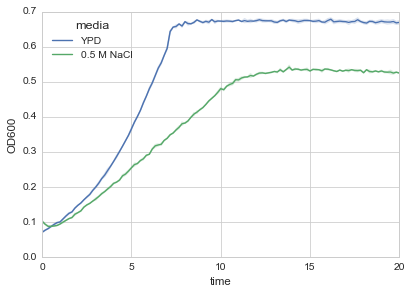

In [22]:
fig = plt.figure()
ax = sns.tsplot(data=lf_data, time='time', value='OD600', unit='sample', condition='media', err_style='unit_traces')
#fig.savefig('/Users/nwespe/Desktop/OD600_growth.png', dpi=200, bbox_inches='tight')

In [23]:
subset = trimmed_log_data[trimmed_log_data.name == strain]
lf_log_data = pd.melt(subset, id_vars = ['name', 'media', 'expt_date', 'well'], var_name='time', value_name='OD600')
lf_log_data['expt_date'] = lf_log_data['expt_date'].apply(lambda x: x.strftime('%Y-%m-%d'))
lf_log_data['sample'] = lf_log_data['expt_date'] + ' ' + lf_log_data['well']

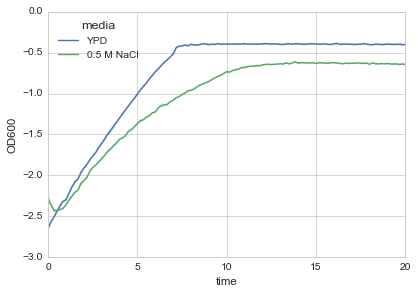

In [24]:
fig = plt.figure()
ax = sns.tsplot(data=lf_log_data, time='time', value='OD600', unit='sample', condition='media', err_style='unit_traces')

In [25]:
subset = trimmed_norm_data[trimmed_norm_data.name == strain]
lf_norm_data = pd.melt(subset, id_vars = ['name', 'media', 'expt_date', 'well'], var_name='time', value_name='OD/init OD')
lf_norm_data['expt_date'] = lf_norm_data['expt_date'].apply(lambda x: x.strftime('%Y-%m-%d'))
lf_norm_data['sample'] = lf_norm_data['expt_date'] + ' ' + lf_norm_data['well']

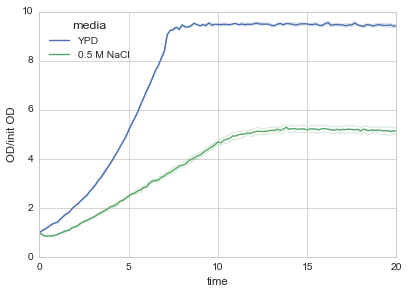

In [26]:
fig = plt.figure()
ax = sns.tsplot(data=lf_norm_data, time='time', value='OD/init OD', unit='sample', condition='media', err_style="unit_traces")
#fig.savefig('/Users/nwespe/Desktop/OD_div_initOD_growth.png', dpi=200, bbox_inches='tight')

In [27]:
subset = trimmed_log_norm_data[trimmed_log_norm_data.name == strain]
lf_log_norm_data = pd.melt(subset, id_vars = ['name', 'media', 'expt_date', 'well'], var_name='time', value_name='ln(OD600/init OD)')
lf_log_norm_data['expt_date'] = lf_log_norm_data['expt_date'].apply(lambda x: x.strftime('%Y-%m-%d'))
lf_log_norm_data['sample'] = lf_log_norm_data['expt_date'] + ' ' + lf_log_norm_data['well']

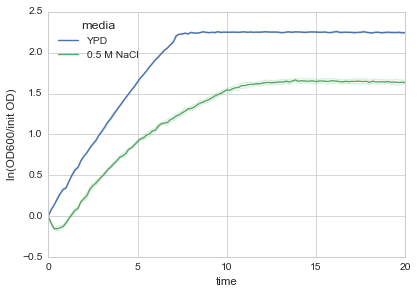

In [28]:
fig = plt.figure()
#ax = sns.tsplot(data=lf_log_data, time='time', value='OD600', unit='sample', condition='media', err_style='unit_traces')
ax = sns.tsplot(data=lf_log_norm_data, time='time', value='ln(OD600/init OD)', unit='sample', condition='media', err_style="unit_traces")
#fig.savefig('/Users/nwespe/Desktop/ln_OD_div_initOD_growth.png', dpi=200, bbox_inches='tight')

In [29]:
subset = trimmed_subtracted_data[trimmed_subtracted_data.name == strain]
lf_subtracted_data = pd.melt(subset, id_vars = ['name', 'media', 'expt_date', 'well'], var_name='time', value_name='OD600 - init OD')
lf_subtracted_data['expt_date'] = lf_subtracted_data['expt_date'].apply(lambda x: x.strftime('%Y-%m-%d'))
lf_subtracted_data['sample'] = lf_subtracted_data['expt_date'] + ' ' + lf_subtracted_data['well']

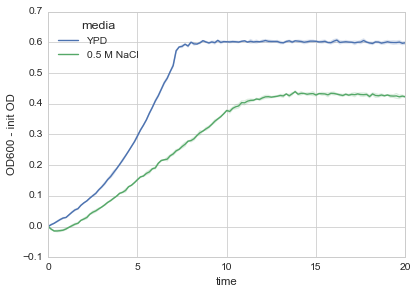

In [30]:
fig = plt.figure()
ax = sns.tsplot(data=lf_subtracted_data, time='time', value='OD600 - init OD', unit='sample', condition='media', err_style="unit_traces")
#fig.savefig('/Users/nwespe/Desktop/OD-initOD_growth.png', dpi=200, bbox_inches='tight')

In [31]:
pd.unique(trimmed_data.name)

array(['003', '006A', '115', '209', '116', '210', '190', '226', '191',
       '219', '207', '208', '034A', '215', '111c3', '255', '178', '169',
       'blank', '114', '216', '202', '170', '110-c4', '248', '112E', '217',
       '249', '224', '247', '212', '012', '260', '113A', '229', '227',
       '228', nan, '128', '232', '234', '238', '240', '242', '033B', '213',
       '035C', '256A', '258A', '188', '214', '087', '088', '257', '127',
       '231', '233', '235', '237', '239', '241', '243', '230', '236',
       '207B', '129', '130', '028A', '028B', '028C', '118A', '=G61&H61'], dtype=object)

In [111]:
gene_dict = {'003': 'wild-type', '006A': 'mec1- sml1-', '028A': 'mut anc A', '028B': 'mut anc B', '028C': 'mut anc C',
             '207': 'imp2- A', '207B': 'imp2- B', '129': 'trk1-', '130': 'm1s1 trk1-',
             '087': 'hal5-', '088': 'm1s1 hal5-', '012': 'hog1-', '260': 'm1s1 hog1-',
             '033B': 'evo1', '188': 'evo1 HAL5-wt', '213': 'm1s1 hal5-G515W', '214': 'hal5-G515W', 
             '034A': 'evo2', '215': 'evo2 HXT1-wt', '169': 'm1s1 HXT1-S333Y', '178': 'HXT1-S333Y',
             '035C': 'evo3', '256A': 'evo3 HXT7-wt', '258A': 'm1s1 HXT7-G84D', '257': 'HXT7-G84D', 
             '110-c4': 'evo4', '248': 'evo4 HOG1-wt', '247': 'm1s1 hog1-A166V', '249': 'hog1-A166V', 
             '111c3': 'evo5', '255': 'evo5 HXT1-wt',
             '112E': 'evo6', '217': 'evo6 HOG1-wt', '212': 'm1s1 hog1-G175D', '224': 'hog1-G175D', 
             '113A': 'evo7', '229': 'evo7 HXT3-wt', '228': 'm1s1 HXT3-A438V', '227': 'HXT3-A438V',
             '114': 'evo9', '216': 'evo9 HXT1-wt', '170': 'm1s1 HXT1-T362A', '202': 'HXT1-T362A',
             '115': 'evo10', '209': 'evo10 IMP2-wt', '191': 'm1s1 IMP2-L309R', '190': 'IMP2-L309R',
             '116': 'evo11', '210': 'evo11 IMP2-wt', '219': 'm1s1 IMP2-E124*', '226': 'IMP2-E124*',
             '127': 'far1-', '231':' f1 hal5-G515W', '233': 'f1 hog1-G175D', '235': 'f1 HXT1-S333Y',
             '237': 'f1 HXT1-T362A', '239': 'f1 HXT3-A438V', '241': 'f1 IMP2-L309R', '243': 'f1 IMP2-E124*',
             '128': 'sic1-', '230':' s1 hal5-G515W', '232': 's1 hog1-G175D', '234': 's1 HXT1-S333Y',
             '236': 's1 HXT1-T362A', '238': 's1 HXT3-A438V', '240': 's1 IMP2-L309R', '242': 's1 IMP2-E124*'}

In [151]:
strains = ['003', '006A', '214', '213', '129', '130', '033B', '188']
#['003', '214', '006A', '213', '028A', '033B']
#['003', '214', '128', '230', '127', '231']
#['003', '227', '128', '238', '127', '239']
#['003', '127', '224', '233']
#['110-c4', '248', '006A', '247', '003', '249']
#['112E', '217', '006A', '212', '003', '224']
#['033B', '188', '006A', '213', '003', '214', '087', '088']
#['035C', '256A', '006A', '258A', '003', '257']
#['033B', '188', '006A', '213', '003', '214']
#['006A', '170', '114', '216']
#['006A', '113A', '228', '229']

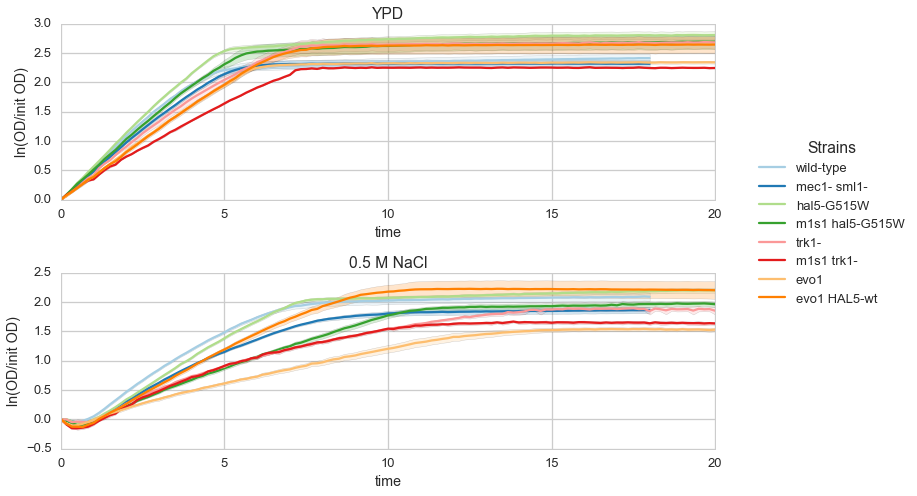

In [152]:
# for multiple strains on one plot, with media split into 2 plots
fig = plt.figure()
palette = sns.color_palette('Paired', 2*len(strains))
media = ['YPD', '0.5 M NaCl']
media1_data = trimmed_log_norm_data[trimmed_log_norm_data.media == media[0]]
media2_data = trimmed_log_norm_data[trimmed_log_norm_data.media == media[1]]
med1 = fig.add_subplot(211)
x, y = 0, 1
for s in strains:
    #color_dict = {media[0]: palette[x], media[1]: palette[y]}
    #x += 2; y += 2
    subset = media1_data[media1_data.name == s]
    lf_log_norm_data = pd.melt(subset, id_vars = ['name', 'media', 'expt_date', 'well'], var_name='time', value_name='ln(OD/init OD)')
    lf_log_norm_data['expt_date'] = lf_log_norm_data['expt_date'].apply(lambda x: x.strftime('%Y-%m-%d'))
    lf_log_norm_data['sample'] = lf_log_norm_data['expt_date'] + ' ' + lf_log_norm_data['well']
    sns.tsplot(data=lf_log_norm_data, time='time', value='ln(OD/init OD)', unit='sample', condition='media', color = palette[x], legend=False) #, err_style=None) #err_style='unit_traces', 
    x += 1
plt.title(media[0])

med2 = fig.add_subplot(212)
x, y = 0, 1
for s in strains:
    #color_dict = {media[0]: palette[x], media[1]: palette[y]}
    #x += 2; y += 2
    subset = media2_data[media2_data.name == s]
    lf_log_norm_data = pd.melt(subset, id_vars = ['name', 'media', 'expt_date', 'well'], var_name='time', value_name='ln(OD/init OD)')
    lf_log_norm_data['expt_date'] = lf_log_norm_data['expt_date'].apply(lambda x: x.strftime('%Y-%m-%d'))
    lf_log_norm_data['sample'] = lf_log_norm_data['expt_date'] + ' ' + lf_log_norm_data['well']
    sns.tsplot(data=lf_log_norm_data, time='time', value='ln(OD/init OD)', unit='sample', condition='media', color = palette[x]) #, err_style=None) #err_style='unit_traces', 
    x += 1
plt.title(media[1])

legend_labels1, legend_labels2 = [], []  
for s in strains: 
    genotype = gene_dict[s]
    legend_labels1.append(genotype)
    legend_labels2.append(genotype)
#med1.legend(legend_labels1, title = 'Strains', loc=2, bbox_to_anchor=(1, 1))
med2.legend(legend_labels2, title = 'Strains', loc=3, bbox_to_anchor=(1.05, 0.75))
plt.tight_layout()

In [148]:
#fig.savefig('/Users/nwespe/Desktop/hog1_m1s1_strains_ci68_split.png', dpi=200, bbox_inches='tight')

In [157]:
trimmed_log_norm_data.iloc[:3, 12:37]

,2.0,2.16666666667,2.33333333333,2.5,2.66666666667,2.83333333333,3.0,3.16666666667,3.33333333333,3.5,...,4.5,4.66666666667,4.83333333333,5.0,5.16666666667,5.33333333333,5.5,5.66666666667,5.83333333333,6.0
0,1.031921,1.111964,1.193434,1.266493,1.332451,1.414129,1.480504,1.537561,1.645863,1.694431,...,1.992064,2.038283,2.047693,2.038283,2.025598,2.029845,2.048733,2.055983,2.062156,2.069310
1,1.064421,1.153122,1.229690,1.305376,1.373609,1.461152,1.525325,1.585627,1.676075,1.729646,...,2.027706,2.052830,2.063560,2.052830,2.048506,2.048506,2.061423,2.061423,2.071003,2.071003
2,0.940457,1.018769,1.079241,1.159096,1.216129,1.296008,1.357095,1.412915,1.512832,1.560792,...,1.921988,1.947964,1.981250,1.994064,2.012502,2.004780,1.999923,1.994064,1.999923,2.004780


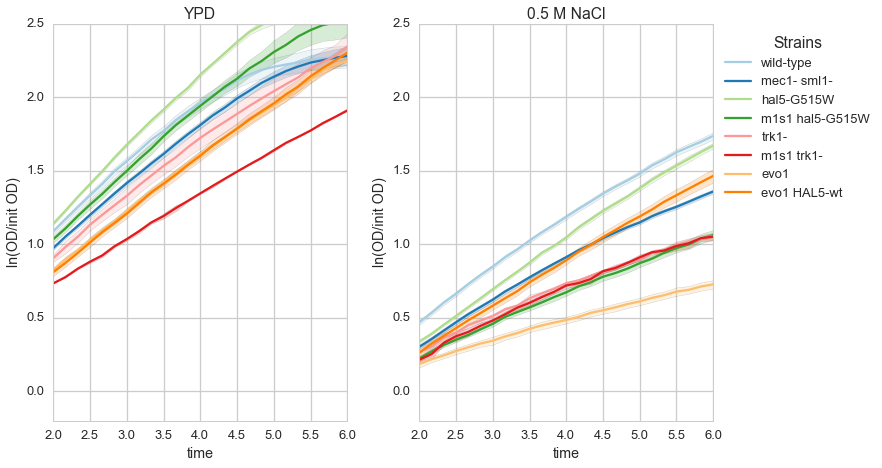

In [158]:
# for first 6 hours only
sns.set_context('talk')
first_six_hrs = pd.concat([trimmed_log_norm_data.iloc[:, 0:37], trimmed_log_norm_data.iloc[:, -4:]], axis=1)
two_six_hrs = pd.concat([trimmed_log_norm_data.iloc[:, 12:37], trimmed_log_norm_data.iloc[:, -4:]], axis=1)
data = two_six_hrs
# for multiple strains on one plot, with media split into 2 plots
fig = plt.figure()
palette = sns.color_palette('Paired', 2*len(strains))
media = ['YPD', '0.5 M NaCl']
media1_data = data[data.media == media[0]]
media2_data = data[data.media == media[1]]
med1 = fig.add_subplot(121, adjustable='box', aspect=2)
x, y = 0, 1
for s in strains:
    #color_dict = {media[0]: palette[x], media[1]: palette[y]}
    #x += 2; y += 2
    subset = media1_data[media1_data.name == s]
    lf_log_norm_data = pd.melt(subset, id_vars = ['name', 'media', 'expt_date', 'well'], var_name='time', value_name='ln(OD/init OD)')
    lf_log_norm_data['expt_date'] = lf_log_norm_data['expt_date'].apply(lambda x: x.strftime('%Y-%m-%d'))
    lf_log_norm_data['sample'] = lf_log_norm_data['expt_date'] + ' ' + lf_log_norm_data['well']
    ax1 = sns.tsplot(data=lf_log_norm_data, time='time', value='ln(OD/init OD)', unit='sample', condition='media', color = palette[x], legend=False) #, err_style=None) #err_style='unit_traces', 
    x += 1
ax1.set_ylim(-0.2, 2.5)
plt.title(media[0])

med2 = fig.add_subplot(122, adjustable='box', aspect=2)
x, y = 0, 1
for s in strains:
    #color_dict = {media[0]: palette[x], media[1]: palette[y]}
    #x += 2; y += 2
    subset = media2_data[media2_data.name == s]
    lf_log_norm_data = pd.melt(subset, id_vars = ['name', 'media', 'expt_date', 'well'], var_name='time', value_name='ln(OD/init OD)')
    lf_log_norm_data['expt_date'] = lf_log_norm_data['expt_date'].apply(lambda x: x.strftime('%Y-%m-%d'))
    lf_log_norm_data['sample'] = lf_log_norm_data['expt_date'] + ' ' + lf_log_norm_data['well']
    ax2 = sns.tsplot(data=lf_log_norm_data, time='time', value='ln(OD/init OD)', unit='sample', condition='media', color = palette[x]) #, err_style=None) #err_style='unit_traces', 
    x += 1
ax2.set_ylim(-0.2, 2.5)
plt.title(media[1])

legend_labels1, legend_labels2 = [], []  
for s in strains: 
    genotype = gene_dict[s]
    legend_labels1.append(genotype)
    legend_labels2.append(genotype)
#med1.legend(legend_labels1, title = '', loc='upper left')
med2.legend(legend_labels2, title = 'Strains', bbox_to_anchor=(1,1), loc=2)
plt.tight_layout()

In [154]:
fig.savefig('/Users/nwespe/Desktop/evo1_trk1_strains_6hrs.png', dpi=200, bbox_inches='tight')

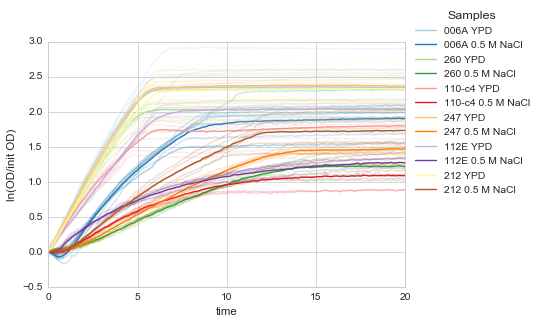

In [46]:
# for multiple strains on one plot
fig = plt.figure()
palette = sns.color_palette('Paired', 4*len(strains))
x, y = 0, 1
media = ['YPD', '0.5 M NaCl']
legend_labels = []
for s in strains:
    color_dict = {media[0]: palette[x], media[1]: palette[y]}
    x += 2; y += 2
    subset = trimmed_log_norm_data[trimmed_log_norm_data.name == s]
    lf_log_norm_data = pd.melt(subset, id_vars = ['name', 'media', 'expt_date', 'well'], var_name='time', value_name='ln(OD/init OD)')
    lf_log_norm_data['expt_date'] = lf_log_norm_data['expt_date'].apply(lambda x: x.strftime('%Y-%m-%d'))
    lf_log_norm_data['sample'] = lf_log_norm_data['expt_date'] + ' ' + lf_log_norm_data['well']
    ax = sns.tsplot(data=lf_log_norm_data, time='time', value='ln(OD/init OD)', unit='sample', condition='media', color = color_dict, err_style='unit_traces') #, err_style=None) #err_style='unit_traces' 
for s in strains: 
    legend_labels.extend([s +' '+ media[0], s +' '+ media[1]])
ax.legend(legend_labels, title = 'Samples', loc='center left', bbox_to_anchor=(1, 0.75))
#fig.savefig('/Users/nwespe/Desktop/003_traces_unblanked.png', dpi=200, bbox_inches='tight')

In [ ]:
# view by dates 
fig = plt.figure()
palette = sns.color_palette('Paired', 4*len(strains))
x, y = 0, 1
#dates = ['20160908', '20160913', '20160922']
#media = ['YPD', '0.5 M NaCl']
legend_labels = []
for s in strains:
    #color_dict = {media[0]: palette[x], media[1]: palette[y]}
    x += 2; y += 2
    subset = trimmed_log_norm_data[trimmed_log_norm_data.name == s]
    lf_log_norm_data = pd.melt(subset, id_vars = ['name', 'media', 'expt_date', 'well'], var_name='time', value_name='ln(OD/init OD)')
    lf_log_norm_data['expt_date'] = lf_log_norm_data['expt_date'].apply(lambda x: x.strftime('%Y-%m-%d'))
    lf_log_norm_data['sample'] = lf_log_norm_data['expt_date'] + ' ' + lf_log_norm_data['well']
    ax = sns.tsplot(data=lf_log_norm_data, time='time', value='ln(OD/init OD)', unit='sample', condition='expt_date', err_style='unit_traces') # color = color_dict, err_style=None
for s in strains: 
    legend_labels.extend([s +' '+ dates[0], s +' '+ dates[1], s +' '+ dates[2]])
ax.legend(legend_labels, title = 'Samples', loc='center left', bbox_to_anchor=(1, 0.75))
#fig.savefig('/Users/nwespe/Desktop/003_traces_unblanked.png', dpi=200, bbox_inches='tight')

In [ ]:
# for viewing by date, with media split into 2 plots
fig = plt.figure()
palette = sns.color_palette('Paired', 2*len(strains))
media = ['YPD', '0.5 M NaCl']
media1_data = trimmed_log_norm_data[trimmed_log_norm_data.media == media[0]]
media2_data = trimmed_log_norm_data[trimmed_log_norm_data.media == media[1]]

med1 = fig.add_subplot(211)
for s in strains:
    #color_dict = {media[0]: palette[x], media[1]: palette[y]}
    #x += 2; y += 2
    subset = media1_data[media1_data.name == s]
    lf_log_norm_data = pd.melt(subset, id_vars = ['name', 'media', 'expt_date', 'well'], var_name='time', value_name='ln(OD/init OD)')
    lf_log_norm_data['expt_date'] = lf_log_norm_data['expt_date'].apply(lambda x: x.strftime('%Y-%m-%d'))
    lf_log_norm_data['sample'] = lf_log_norm_data['expt_date'] + ' ' + lf_log_norm_data['well']
    sns.tsplot(data=lf_log_norm_data, time='time', value='ln(OD/init OD)', unit='sample', condition='expt_date', err_style='unit_traces') #, err_style=None) #, 

med2 = fig.add_subplot(212)
for s in strains:
    subset = media2_data[media2_data.name == s]
    lf_log_norm_data = pd.melt(subset, id_vars = ['name', 'media', 'expt_date', 'well'], var_name='time', value_name='ln(OD/init OD)')
    lf_log_norm_data['expt_date'] = lf_log_norm_data['expt_date'].apply(lambda x: x.strftime('%Y-%m-%d'))
    lf_log_norm_data['sample'] = lf_log_norm_data['expt_date'] + ' ' + lf_log_norm_data['well']
    sns.tsplot(data=lf_log_norm_data, time='time', value='ln(OD/init OD)', unit='sample', condition='expt_date', err_style='unit_traces') #, err_style=None) # 

legend_labels1, legend_labels2 = [], []  
for s in strains: 
    legend_labels1.extend([s +' '+ dates[0], s +' '+ dates[1], s +' '+ dates[2]])
    legend_labels2.extend([s +' '+ dates[0], s +' '+ dates[1], s +' '+ dates[2]])
med1.legend(legend_labels1, title = media[0], loc='center left', bbox_to_anchor=(1, 0.75))
med2.legend(legend_labels2, title = media[1], loc='center left', bbox_to_anchor=(1, 0.5))

#fig.savefig('/Users/nwespe/Desktop/HXT1-T362A_strains_ci68_split.png', dpi=200, bbox_inches='tight')

In [ ]:
palette = sns.color_palette('Paired')
my_palette = sns.color_palette(['#53585F', '#0365C0', '#F39019', '#70BF41', '#F5D328']) #, '#F5D328'
#sns.set_context('poster', font_scale = 1.3)
#sns.set_style('whitegrid')
#sns.set_palette(my_palette)
sns.palplot(palette)

In [ ]:
colors = ['#53585F', '#0365C0', '#F39019', '#70BF41', '#F5D328']
markers = ['.', '*', '1', 's']

In [ ]:
names = ['006A'] #, '110-c4', '248'
media = pd.unique(plate_layout.media).tolist()

In [ ]:
# want to get well numbers where name = n 
all_wells = []
for n in names:
    wells = plate_layout[plate_layout['name'] == n].well
    all_wells.append(wells)
wells = pd.concat(all_wells)
print wells

In [ ]:
#create new dataframe with data from multiple dates for specified names
gammas = sns.load_dataset("gammas")
gammas[:8]

In [ ]:
wells = ['A3', 'A4', 'E3', 'E4']
fig = plt.figure()
        # orig data with points marked for max growth, lag time, saturation time, and max OD
orig = fig.add_subplot(111)
for w in wells:
    for d in dates:
        data = data_dict[d]
        well_data = data.loc[:, w].values
        name = plate_layout[plate_layout['well'] == w].name.iat[0]
        med = plate_layout[plate_layout['well'] == w].media.iat[0]
        lab = name + ' ' + med
        mar = markers[media.index(med)]
        col = colors[dates.index(d)]
        orig.plot(elapsed_time, well_data, ls='', marker=mar, markersize=15, color=col, label=lab)
orig.autoscale(False)
orig.set_xlim(0, 18)
orig.set_ylim(0, 1.2)
ax = gca()
ax.xaxis.labelpad = 20
ax.yaxis.labelpad = 25
orig.legend(title = 'Samples', loc='center left', bbox_to_anchor=(1, 0.75))
orig.set_xlabel('elapsed time (hours)')
orig.set_ylabel('OD 600')
#fig.savefig('/Users/nwespe/Desktop/ypd_growth.png', dpi=200, bbox_inches='tight')

In [ ]:
ax = sns.tsplot(time=elapsed_time, data=well_data)

In [ ]:
#wells = all_wells
fig = plt.figure()
        # orig data with points marked for max growth, lag time, saturation time, and max OD
orig = fig.add_subplot(111)
for w in wells:
    for d in dates:
        data = data_dict[d]
        well_data = data.loc[:, w].values
        name = plate_layout[plate_layout['well'] == w].name.iat[0]
        med = plate_layout[plate_layout['well'] == w].media.iat[0]
        lab = name + ' ' + med
        mar = markers[media.index(med)]
        col = colors[dates.index(d)]
        norm_data = well_data/well_data[0]
        orig.plot(elapsed_time, norm_data, ls='', marker=mar, color = col, markersize=15, label=lab)
orig.autoscale(False)
orig.set_xlim(0, 18)
#orig.set_ylim(0, 1.2)
ax = gca()
ax.xaxis.labelpad = 20
ax.yaxis.labelpad = 25
orig.legend(title = 'Samples', loc='center left', bbox_to_anchor=(1, 0.75))
orig.set_xlabel('elapsed time (hours)')
orig.set_ylabel('OD 600 / init OD 600')
#fig.savefig('/Users/nwespe/Desktop/ypd_growth.png', dpi=200, bbox_inches='tight')

In [ ]:
#wells = all_wells
fig = plt.figure()
        # orig data with points marked for max growth, lag time, saturation time, and max OD
orig = fig.add_subplot(111)
for w in wells:
    for d in dates:
        data = data_dict[d]
        well_data = data.loc[:, w].values
        log_norm_data = np.log(well_data/well_data[0])
        name = plate_layout[plate_layout['well'] == w].name.iat[0]
        med = plate_layout[plate_layout['well'] == w].media.iat[0]
        lab = name + ' ' + med
        mar = markers[media.index(med)]
        col = colors[dates.index(d)]
        orig.plot(elapsed_time, log_norm_data, ls='', marker=mar, color=col, markersize=15, label=lab)
orig.autoscale(False)
orig.set_xlim(0, 18)
#orig.set_ylim(0, 1.2)
ax = gca()
ax.xaxis.labelpad = 20
ax.yaxis.labelpad = 25
orig.legend(title = 'Samples', loc='center left', bbox_to_anchor=(1, 0.75))
orig.set_xlabel('elapsed time (hours)')
orig.set_ylabel('ln (OD 600 / init OD 600)')
#fig.savefig('/Users/nwespe/Desktop/ypd_growth.png', dpi=200, bbox_inches='tight')

In [ ]:
fig = plt.figure()
        # orig data with points marked for max growth, lag time, saturation time, and max OD
orig = fig.add_subplot(111)
orig.plot(elapsed_time, samples['A2'], ls='', marker='.', markersize=15, label='wild-type')
orig.plot(elapsed_time, samples['C10'], ls='', marker='.', markersize=15, label='HXT1-S333Y')
orig.plot(elapsed_time, samples['D7'], ls='', marker='.', markersize=15, label='HXT1-T362A')
orig.plot(elapsed_time, samples['C5'], ls='', marker='.', markersize=15, label='HXT3-A438V')
orig.autoscale(False)
orig.set_xlim(0, 18)
orig.set_ylim(0, 1.2)
ax = gca()
ax.xaxis.labelpad = 20
ax.yaxis.labelpad = 25
orig.legend(title = 'Standard Media', loc='center left', bbox_to_anchor=(1, 0.75))
orig.set_xlabel('elapsed time (hours)')
orig.set_ylabel('OD 600')
fig.savefig('/Users/nwespe/Desktop/ypd_growth.png', dpi=200, bbox_inches='tight')

In [ ]:
plate_layout

In [ ]:
fig = plt.figure()
        # orig data with points marked for max growth, lag time, saturation time, and max OD
orig = fig.add_subplot(111)
orig.plot(elapsed_time, samples['E2'], ls='', marker='*', markersize=10, label='wild-type')
orig.plot(elapsed_time, samples['G10'], ls='', marker='*', markersize=10, label='HXT1-S333Y')
orig.plot(elapsed_time, samples['H7'], ls='', marker='*', markersize=10, label='HXT1-T362A')
orig.plot(elapsed_time, samples['G5'], ls='', marker='*', markersize=10, label='HXT3-A438V')
orig.autoscale(False)
orig.set_xlim(0, 18)
orig.set_ylim(0, 1.2)
ax = gca()
ax.xaxis.labelpad = 20
ax.yaxis.labelpad = 25
orig.legend(title = '0.5 M NaCl', loc='center left', bbox_to_anchor=(1, 0.25))
orig.set_ylabel('OD 600')
orig.set_xlabel('elapsed time (hours)')
fig.savefig('/Users/nwespe/Desktop/nacl_growth.png', dpi=200, bbox_inches='tight', transparent=True)